In [1]:
pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 2.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import json
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, RobertaTokenizer, AutoModelForQuestionAnswering
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import wandb
from datasets import Dataset
import os
from collections import defaultdict
import numpy as np
from torch.utils.data import DataLoader
from transformers import AdamW
import evaluate
from transformers import default_data_collator
from transformers import Trainer
from tqdm.auto import tqdm
from transformers import TrainingArguments
from accelerate import Accelerator
from transformers import get_scheduler
import re

os.environ["TOKENIZERS_PARALLELISM"] = "false"

tqdm.pandas()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
errorUuid = {"ad9271b7-9983-42f5-9bd9-fdfcb171ddaa":[[[4, 37],[4, 222]]]}
def parse_spoiler(x):
    spoiler = []
    if x['uuid'] in errorUuid:
        x['spoilerPositions'] = errorUuid[x['uuid']]

    for s in x['spoilerPositions']:
        st,en = s[0],s[1]
        spoiler.append(x['targetParagraphs'][st[0]][st[1]:en[1]])
        
    return spoiler

def findPosTags(x):    
    tokPos = []
    for pos in x['spoilerPositions']:
        st,en = pos
        idx = 0
        for i,p in enumerate([x['targetTitle']] + x['targetParagraphs']):
            if i==st[0]+1:
                start_ind = idx+st[1]
                end_ind = idx + en[1]
                
                tokPos.append([start_ind,end_ind])
                break
            if i==0:
                idx+=len(p)+3
            else:
                idx+=len(p)+1
        
    return tokPos

def read_prep(path,train=True):
    with open(path, 'rb') as json_file:
        json_list = list(json_file)

    results = []
    for json_str in json_list:
        result = json.loads(json_str)
        results.append(result)
    df = pd.DataFrame(results)
    df['tags'] = df.tags.apply(lambda x:x[0],1)
    df['postText'] = df.postText.apply(lambda x:x[0],1)    
    
    # Parsing for faulty spoiler ids
    df['spoilerParsed'] = df.apply(parse_spoiler,1)
    df['mergedParas'] = df['targetParagraphs'].apply(lambda x:" ".join(x),1)
    df.mergedParas = df.targetTitle + " - " + df.mergedParas
    df['tokPos'] = df.apply(findPosTags,1)
    df['label'] = df['tags'].map({"phrase":0,"passage":1,"multi":2})
    
    return df

In [4]:
df_train = read_prep("/kaggle/input/webisclickbait/webis-clickbait-22/train.jsonl")
df_valid = read_prep("/kaggle/input/webisclickbait/webis-clickbait-22/validation.jsonl")

In [5]:
def read_prep(path,train=True):
    with open(path, 'rb') as json_file:
        json_list = list(json_file)

    results = []
    for json_str in json_list:
        result = json.loads(json_str)
        results.append(result)
    df = pd.DataFrame(results)
    df['postText'] = df.postText.apply(lambda x:x[0],1)    
    
    # Parsing for faulty spoiler ids
    df['mergedParas'] = df['targetParagraphs'].apply(lambda x:" ".join(x),1)
    df.mergedParas = df.targetTitle + " - " + df.mergedParas
    
    return df

In [6]:
df_test = read_prep("/kaggle/input/skkonda/test.jsonl")

**ROBERTA BASE MODEL**

In [7]:
config = dict(
    epochs=5,
    classes=3,
    batch_size=8,
    learning_rate=1e-5,
    model="roberta-base")

In [8]:
# tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
tokenizer = AutoTokenizer.from_pretrained(config['model'], do_lower_case=True)
model = AutoModelForSequenceClassification.from_pretrained(config['model'],num_labels=config['classes'])

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias', 'classifier.dense.weight']
You should pr

In [9]:
import numpy as np

def tokenize(examples):
    tokenized_examples = tokenizer(examples['postText'],
                                   examples['mergedParas'],
                                   truncation=True,
                                   max_length=512,
                                   padding=True,
                                   return_tensors='np')
    
    return {
        'input_ids': tokenized_examples['input_ids'].tolist(),
        'attention_mask': tokenized_examples['attention_mask'].tolist()
    }


In [10]:
train_data = Dataset.from_pandas(df_train[['postText',"mergedParas","label"]])
val_data = Dataset.from_pandas(df_valid[['postText',"mergedParas","label"]])
test_data = Dataset.from_pandas(df_test[['postText',"mergedParas"]])

In [11]:
train_dataset = train_data.map(tokenize,batched=True,remove_columns=["postText","mergedParas"])
train_dataset.set_format("torch")

  0%|          | 0/4 [00:00<?, ?ba/s]

In [12]:
val_dataset = val_data.map(tokenize,batched=True,remove_columns=["postText","mergedParas"])
val_dataset.set_format("torch")

  0%|          | 0/1 [00:00<?, ?ba/s]

In [13]:
test_dataset = test_data.map(tokenize,batched=True,remove_columns=["postText","mergedParas"])
test_dataset.set_format("torch")

  0%|          | 0/1 [00:00<?, ?ba/s]

In [14]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

# Assume you have a list to store the epoch metric values
epoch_metrics_list = []

def compute_metrics(eval_preds):
    preds = np.argmax(eval_preds.predictions, axis=1)
    labels = eval_preds.label_ids

    accuracy = (preds == labels).astype(np.float32).mean().item()

    # Calculate precision, recall, and F1-score
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')

    # Calculate the confusion matrix
    cm = confusion_matrix(labels, preds)

    # Append the metrics and confusion matrix for this epoch to the epoch_metrics_list
    epoch_metrics_list.append({
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "confusion_matrix": cm
    })

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "confusion_matrix": cm
    }


In [17]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
from transformers import TrainingArguments, Trainer, TrainerCallback
from transformers import TrainingArguments
training_args = TrainingArguments(
    output_dir="./trainer_task1_bert",
    learning_rate=config['learning_rate'],
    per_device_train_batch_size=config['batch_size'],
    per_device_eval_batch_size=config['batch_size'],
    num_train_epochs=config['epochs'],
    weight_decay=0.01,
    evaluation_strategy ="epoch",
    save_strategy="no"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics = compute_metrics,
)


# Your compute_metrics function remains unchanged

# Start the training process
trainer.train()


/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Confusion Matrix
1,No log,0.729837,0.711250,0.736360,0.711250,0.705337,[[231 102 2] [ 46 272 4] [ 37 40 66]]
2,No log,0.717553,0.718750,0.718923,0.718750,0.718234,[[254 71 10] [ 70 228 24] [ 27 23 93]]
3,0.555200,0.778971,0.720000,0.724017,0.720000,0.719574,[[228 90 17] [ 47 252 23] [ 22 25 96]]
4,0.555200,0.852631,0.715000,0.715427,0.715000,0.714279,[[256 70 9] [ 73 224 25] [ 31 20 92]]
5,0.298600,0.876597,0.721250,0.721975,0.721250,0.720642,[[248 75 12] [ 63 239 20] [ 28 25 90]]


Trainer is attempting to log a value of "[[231 102   2]
 [ 46 272   4]
 [ 37  40  66]]" of type <class 'numpy.ndarray'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Trainer is attempting to log a value of "[[254  71  10]
 [ 70 228  24]
 [ 27  23  93]]" of type <class 'numpy.ndarray'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vect

TrainOutput(global_step=1000, training_loss=0.4269148864746094, metrics={'train_runtime': 951.1264, 'train_samples_per_second': 16.822, 'train_steps_per_second': 1.051, 'total_flos': 4209814683648000.0, 'train_loss': 0.4269148864746094, 'epoch': 5.0})

In [18]:
# After all epochs, create a DataFrame from the list of metrics
epoch_metrics_df_roberta = pd.DataFrame(epoch_metrics_list)


In [20]:
epoch_metrics_df_roberta[5:10]

,accuracy,precision,recall,f1,confusion_matrix
5,0.71125,0.736360,0.71125,0.705337,"[[231, 102, 2], [46, 272, 4], [37, 40, 66]]"
6,0.71875,0.718923,0.71875,0.718234,"[[254, 71, 10], [70, 228, 24], [27, 23, 93]]"
7,0.72000,0.724017,0.72000,0.719574,"[[228, 90, 17], [47, 252, 23], [22, 25, 96]]"
8,0.71500,0.715427,0.71500,0.714279,"[[256, 70, 9], [73, 224, 25], [31, 20, 92]]"


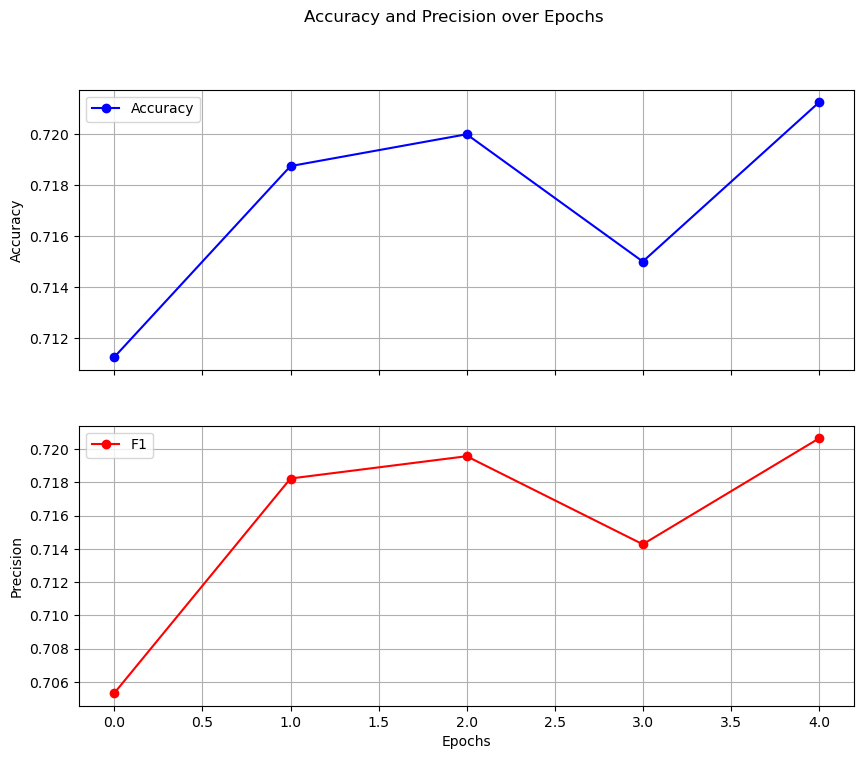

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Data for accuracy and precision
epochs = np.arange(5)  # Assuming you have 10 epochs

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot accuracy
ax1.plot(epochs, epoch_metrics_df_roberta[5:10]['accuracy'], label='Accuracy', marker='o', color='b')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Plot precision
ax2.plot(epochs, epoch_metrics_df_roberta[5:10]['f1'], label='F1', marker='o', color='r')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Precision')
ax2.legend()
ax2.grid(True)

plt.suptitle('Accuracy and Precision over Epochs')
plt.show()

[[248  75  12]
 [ 63 239  20]
 [ 28  25  90]]


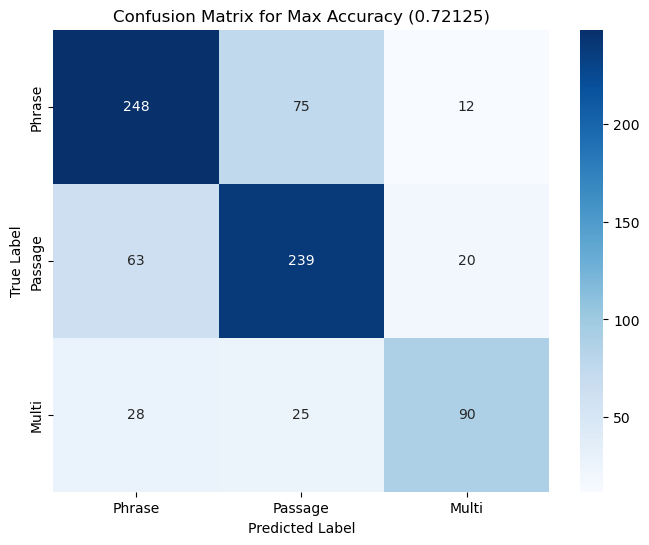

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Assuming you have a list of class labels
class_labels = ['Phrase', 'Passage', 'Multi']

# Assuming you already have the confusion matrix 'cm' with the maximum accuracy
max_accuracy = max(epoch_metrics_df_roberta['accuracy'])
cm = epoch_metrics_df_roberta.loc[epoch_metrics_df_roberta['accuracy'] == max_accuracy, 'confusion_matrix'].to_numpy()[0]
print(cm)
# Plot the confusion matrix
plot_confusion_matrix(cm, classes=class_labels, title=f'Confusion Matrix for Max Accuracy ({max_accuracy:.5f})')


In [23]:
def get_label_name(label_id):
    if label_id == 0:
        return "phrase"
    elif label_id == 1:
        return "passage"
    elif label_id == 2:
        return "multi"
    else:
        return "Unknown Label"


In [24]:
# Assuming you have already defined the 'trainer' object as shown in your code...

# Make predictions on the evaluation dataset
predictions = trainer.predict(test_dataset)

# 'predictions' is a NamedTuple object with the following attributes:
# predictions.predictions: The model's raw predictions (e.g., logits)
# predictions.label_ids: The true labels for the evaluation dataset


# 'metrics' will contain the computed evaluation metrics for the predictions made by the model.

# If you only want to get the predicted labels (not for metric computation):
predicted_label_ids = np.argmax(predictions.predictions, axis=1)

# 'predicted_label_ids' will contain the predicted label indices (0, 1, 2, etc.)

# Assuming you have a function 'get_label_name' that maps the label index to the actual label name.
predicted_labels = [get_label_name(label_id) for label_id in predicted_label_ids]

# 'predicted_labels' will contain the human-readable label names.
predicted_text = pd.DataFrame(predicted_labels,columns = ['Label'])
id_data = pd.DataFrame(df_test['id'])
Output = pd.concat([id_data,predicted_text],axis =1)
# Print or use the predicted labels as needed
print(predicted_labels)


['phrase', 'passage', 'phrase', 'phrase', 'passage', 'phrase', 'multi', 'multi', 'phrase', 'multi', 'phrase', 'multi', 'phrase', 'passage', 'multi', 'phrase', 'passage', 'passage', 'multi', 'phrase', 'phrase', 'passage', 'passage', 'phrase', 'passage', 'passage', 'passage', 'passage', 'passage', 'phrase', 'phrase', 'passage', 'passage', 'passage', 'phrase', 'phrase', 'phrase', 'phrase', 'passage', 'phrase', 'phrase', 'passage', 'phrase', 'passage', 'passage', 'phrase', 'passage', 'phrase', 'passage', 'passage', 'passage', 'multi', 'passage', 'multi', 'passage', 'passage', 'phrase', 'multi', 'passage', 'phrase', 'passage', 'passage', 'passage', 'phrase', 'passage', 'passage', 'passage', 'phrase', 'passage', 'phrase', 'multi', 'phrase', 'multi', 'multi', 'passage', 'passage', 'phrase', 'multi', 'phrase', 'phrase', 'phrase', 'phrase', 'phrase', 'passage', 'phrase', 'passage', 'phrase', 'phrase', 'passage', 'phrase', 'phrase', 'multi', 'multi', 'passage', 'passage', 'phrase', 'passage', 'p

In [25]:
from IPython.display import FileLink
Output.to_csv('output_classification_roberta.csv', index=False)
# Display a link to download the CSV file
FileLink("output_classification_roberta.csv")

/kaggle/working/output_classification_roberta.csv

**DISTILBERT MODEL**

In [26]:
config = dict(
    epochs=5,
    classes=3,
    batch_size=8,
    learning_rate=1e-5,
    model="distilbert-base-uncased")

In [27]:
# tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
tokenizer = AutoTokenizer.from_pretrained(config['model'], do_lower_case=True)
model = AutoModelForSequenceClassification.from_pretrained(config['model'],num_labels=config['classes'])

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.we

In [28]:
import numpy as np

def tokenize(examples):
    tokenized_examples = tokenizer(examples['postText'],
                                   examples['mergedParas'],
                                   truncation=True,
                                   max_length=512,
                                   padding=True,
                                   return_tensors='np')
    
    return {
        'input_ids': tokenized_examples['input_ids'].tolist(),
        'attention_mask': tokenized_examples['attention_mask'].tolist()
    }


In [29]:
train_data = Dataset.from_pandas(df_train[['postText',"mergedParas","label"]])
val_data = Dataset.from_pandas(df_valid[['postText',"mergedParas","label"]])
test_data = Dataset.from_pandas(df_valid[['postText',"mergedParas"]])

In [30]:
train_dataset = train_data.map(tokenize,batched=True,remove_columns=["postText","mergedParas"])
train_dataset.set_format("torch")

  0%|          | 0/4 [00:00<?, ?ba/s]

In [31]:
val_dataset = val_data.map(tokenize,batched=True,remove_columns=["postText","mergedParas"])
val_dataset.set_format("torch")

  0%|          | 0/1 [00:00<?, ?ba/s]

In [32]:
test_dataset = test_data.map(tokenize,batched=True,remove_columns=["postText","mergedParas"])
test_dataset.set_format("torch")

  0%|          | 0/1 [00:00<?, ?ba/s]

In [33]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

# Assume you have a list to store the epoch metric values
epoch_metrics_list_distil = []

def compute_metrics(eval_preds):
    preds = np.argmax(eval_preds.predictions, axis=1)
    labels = eval_preds.label_ids

    accuracy = (preds == labels).astype(np.float32).mean().item()

    # Calculate precision, recall, and F1-score
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')

    # Calculate the confusion matrix
    cm = confusion_matrix(labels, preds)

    # Append the metrics and confusion matrix for this epoch to the epoch_metrics_list
    epoch_metrics_list_distil.append({
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "confusion_matrix": cm
    })

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "confusion_matrix": cm
    }


In [34]:
training_args = TrainingArguments(
    output_dir="./trainer_task1_bert",
    learning_rate=config['learning_rate'],
    per_device_train_batch_size=config['batch_size'],
    per_device_eval_batch_size=config['batch_size'],
    num_train_epochs=config['epochs'],
    weight_decay=0.01,
    evaluation_strategy ="epoch",
    save_strategy="no"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics = compute_metrics,
)

trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Confusion Matrix
1,No log,0.936108,0.557500,0.616508,0.557500,0.541850,[[239 96 0] [148 173 1] [ 60 49 34]]
2,No log,0.808891,0.626250,0.643742,0.626250,0.624033,[[226 104 5] [102 211 9] [ 40 39 64]]
3,0.894600,0.775788,0.647500,0.654431,0.647500,0.646059,[[240 84 11] [106 203 13] [ 34 34 75]]
4,0.894600,0.766521,0.660000,0.665459,0.660000,0.658407,[[235 89 11] [ 89 219 14] [ 36 33 74]]
5,0.668500,0.771315,0.666250,0.670236,0.666250,0.665206,[[220 99 16] [ 75 233 14] [ 31 32 80]]


Trainer is attempting to log a value of "[[239  96   0]
 [148 173   1]
 [ 60  49  34]]" of type <class 'numpy.ndarray'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Trainer is attempting to log a value of "[[226 104   5]
 [102 211   9]
 [ 40  39  64]]" of type <class 'numpy.ndarray'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vect

TrainOutput(global_step=1000, training_loss=0.7815688781738281, metrics={'train_runtime': 482.8987, 'train_samples_per_second': 33.133, 'train_steps_per_second': 2.071, 'total_flos': 2119516176384000.0, 'train_loss': 0.7815688781738281, 'epoch': 5.0})

In [35]:
# After all epochs, create a DataFrame from the list of metrics
epoch_metrics_df_DIST = pd.DataFrame(epoch_metrics_list_distil)
# # Plot confusion matrix for the last epoch (change the index as needed)
# last_epoch_conf_matrix = epoch_metrics_df["confusion_matrix"].iloc[-1]
# plt.figure(figsize=(10, 8))
# sns.heatmap(last_epoch_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1", ...], yticklabels=["Class 0", "Class 1", ...])
# plt.xlabel("Predicted Labels")
# plt.ylabel("True Labels")
# plt.title("Confusion Matrix - Last Epoch")
# plt.show()

In [36]:
epoch_metrics_df_DIST

,accuracy,precision,recall,f1,confusion_matrix
0,0.55750,0.616508,0.55750,0.541850,"[[239, 96, 0], [148, 173, 1], [60, 49, 34]]"
1,0.62625,0.643742,0.62625,0.624033,"[[226, 104, 5], [102, 211, 9], [40, 39, 64]]"
2,0.64750,0.654431,0.64750,0.646059,"[[240, 84, 11], [106, 203, 13], [34, 34, 75]]"
3,0.66000,0.665459,0.66000,0.658407,"[[235, 89, 11], [89, 219, 14], [36, 33, 74]]"
4,0.66625,0.670236,0.66625,0.665206,"[[220, 99, 16], [75, 233, 14], [31, 32, 80]]"


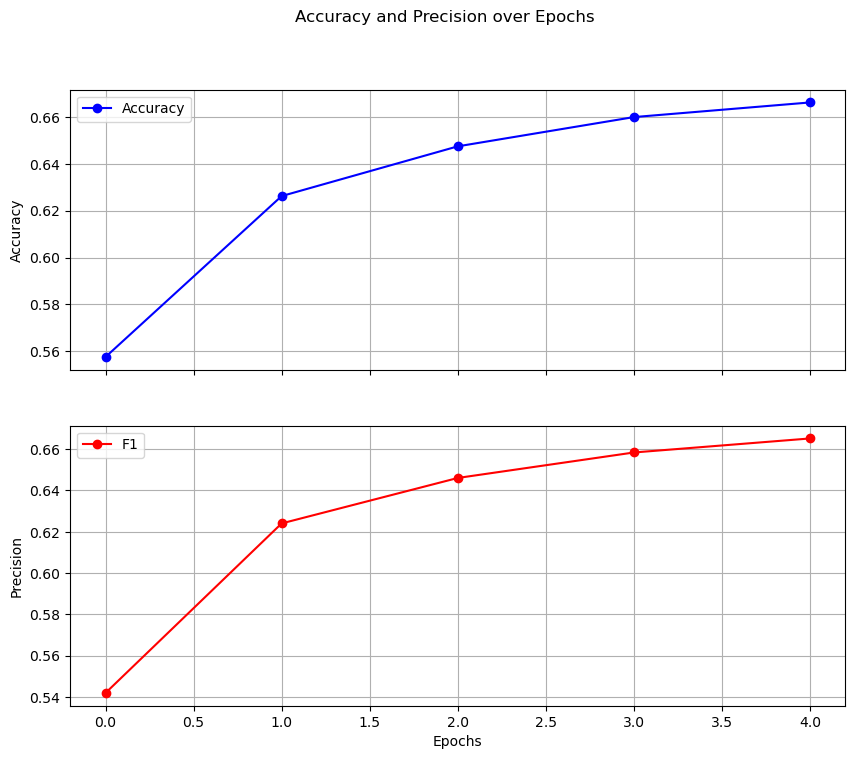

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Data for accuracy and precision
epochs = np.arange(5)  # Assuming you have 10 epochs

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot accuracy
ax1.plot(epochs, epoch_metrics_df_DIST['accuracy'], label='Accuracy', marker='o', color='b')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Plot precision
ax2.plot(epochs, epoch_metrics_df_DIST['f1'], label='F1', marker='o', color='r')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Precision')
ax2.legend()
ax2.grid(True)

plt.suptitle('Accuracy and Precision over Epochs')
plt.show()

[[220  99  16]
 [ 75 233  14]
 [ 31  32  80]]


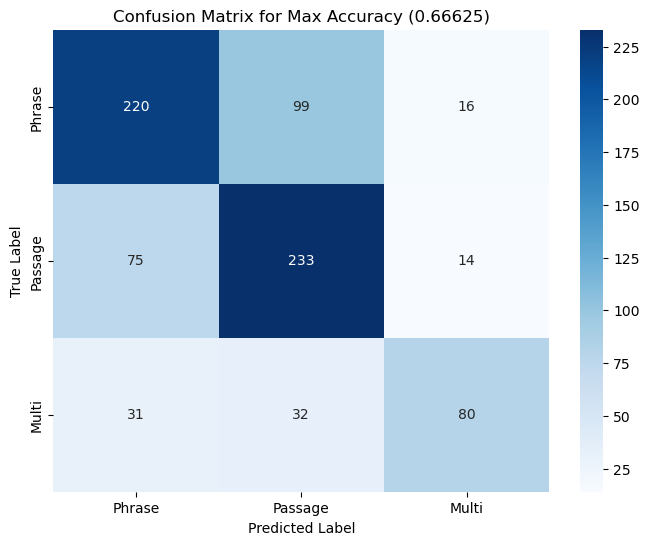

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Assuming you have a list of class labels
class_labels = ['Phrase', 'Passage', 'Multi']

# Assuming you already have the confusion matrix 'cm' with the maximum accuracy
max_accuracy = max(epoch_metrics_df_DIST['accuracy'])
cm = epoch_metrics_df_DIST.loc[epoch_metrics_df_DIST['accuracy'] == max_accuracy, 'confusion_matrix'].to_numpy()[0]
print(cm)
# Plot the confusion matrix
plot_confusion_matrix(cm, classes=class_labels, title=f'Confusion Matrix for Max Accuracy ({max_accuracy:.5f})')


In [40]:
# Assuming you have already defined the 'trainer' object as shown in your code...

# Make predictions on the evaluation dataset
predictions = trainer.predict(test_dataset)

# 'predictions' is a NamedTuple object with the following attributes:
# predictions.predictions: The model's raw predictions (e.g., logits)
# predictions.label_ids: The true labels for the evaluation dataset


# 'metrics' will contain the computed evaluation metrics for the predictions made by the model.

# If you only want to get the predicted labels (not for metric computation):
predicted_label_ids = np.argmax(predictions.predictions, axis=1)

# 'predicted_label_ids' will contain the predicted label indices (0, 1, 2, etc.)

# Assuming you have a function 'get_label_name' that maps the label index to the actual label name.
predicted_labels = [get_label_name(label_id) for label_id in predicted_label_ids]

# 'predicted_labels' will contain the human-readable label names.
predicted_text = pd.DataFrame(predicted_labels,columns = ['Label'])
id_data = pd.DataFrame(df_test['id'])
Output = pd.concat([id_data,predicted_text],axis =1)
# Print or use the predicted labels as needed
print(predicted_labels)


['passage', 'passage', 'phrase', 'phrase', 'passage', 'phrase', 'phrase', 'passage', 'passage', 'passage', 'multi', 'passage', 'multi', 'phrase', 'phrase', 'passage', 'passage', 'passage', 'passage', 'passage', 'passage', 'passage', 'passage', 'phrase', 'passage', 'phrase', 'phrase', 'passage', 'passage', 'phrase', 'passage', 'phrase', 'phrase', 'phrase', 'multi', 'passage', 'phrase', 'multi', 'phrase', 'phrase', 'multi', 'passage', 'phrase', 'passage', 'phrase', 'phrase', 'multi', 'multi', 'phrase', 'passage', 'passage', 'passage', 'phrase', 'phrase', 'phrase', 'passage', 'phrase', 'multi', 'passage', 'phrase', 'phrase', 'multi', 'passage', 'passage', 'passage', 'phrase', 'passage', 'phrase', 'phrase', 'phrase', 'multi', 'passage', 'passage', 'passage', 'phrase', 'phrase', 'phrase', 'phrase', 'passage', 'phrase', 'phrase', 'passage', 'passage', 'phrase', 'passage', 'passage', 'phrase', 'passage', 'passage', 'passage', 'multi', 'multi', 'passage', 'passage', 'phrase', 'passage', 'phras

In [61]:
len(Output)

400

In [41]:
from IPython.display import FileLink
Output.to_csv('output_classification_distill.csv', index=False)
# Display a link to download the CSV file
FileLink("output_classification_distill.csv")

/kaggle/working/output_classification_distill.csv

**DEBERTA BASE MODEL**

In [42]:
config = dict(
    epochs=5,
    classes=3,
    batch_size=4,
    learning_rate=1e-5,
    model="microsoft/deberta-base")

In [43]:
import torch
from transformers import AutoTokenizer
# tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
tokenizer = AutoTokenizer.from_pretrained(config['model'], do_lower_case=True)
model = AutoModelForSequenceClassification.from_pretrained(config['model'],num_labels=config['classes'])

Some weights of the model checkpoint at microsoft/deberta-base were not used when initializing DebertaForSequenceClassification: ['lm_predictions.lm_head.dense.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'lm_predictions.lm_head.LayerNorm.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.bias']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['pooler.dense.bias', 'classifi

In [44]:
import numpy as np

def tokenize(examples):
    tokenized_examples = tokenizer(examples['postText'],
                                   examples['mergedParas'],
                                   truncation=True,
                                   max_length=512,
                                   padding=True,
                                   return_tensors='np')
    
    return {
        'input_ids': tokenized_examples['input_ids'].tolist(),
        'attention_mask': tokenized_examples['attention_mask'].tolist()
    }


In [45]:
train_data = Dataset.from_pandas(df_train[['postText',"mergedParas","label"]])
val_data = Dataset.from_pandas(df_valid[['postText',"mergedParas","label"]])
test_data = Dataset.from_pandas(df_test[['postText',"mergedParas"]])

In [46]:
train_dataset = train_data.map(tokenize,batched=True,remove_columns=["postText","mergedParas"])
train_dataset.set_format("torch")

  0%|          | 0/4 [00:00<?, ?ba/s]

In [48]:
val_dataset = val_data.map(tokenize,batched=True,remove_columns=["postText","mergedParas"])
val_dataset.set_format("torch")

  0%|          | 0/1 [00:00<?, ?ba/s]

In [49]:
test_dataset = test_data.map(tokenize,batched=True,remove_columns=["postText","mergedParas"])
test_dataset.set_format("torch")

  0%|          | 0/1 [00:00<?, ?ba/s]

In [50]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

# Assume you have a list to store the epoch metric values
epoch_metrics_list_deb = []

def compute_metrics(eval_preds):
    preds = np.argmax(eval_preds.predictions, axis=1)
    labels = eval_preds.label_ids

    accuracy = (preds == labels).astype(np.float32).mean().item()

    # Calculate precision, recall, and F1-score
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')

    # Calculate the confusion matrix
    cm = confusion_matrix(labels, preds)

    # Append the metrics and confusion matrix for this epoch to the epoch_metrics_list
    epoch_metrics_list_deb.append({
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "confusion_matrix": cm
    })

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "confusion_matrix": cm
    }


In [51]:
import torch.nn as nn

loss_fn = nn.CrossEntropyLoss()

def compute_loss(model, inputs):
    labels = inputs.pop("labels")
    outputs = model(**inputs)
    logits = outputs.logits
    loss = loss_fn(logits, labels)
    return loss

In [52]:
training_args = TrainingArguments(
    output_dir="./trainer_task1_bert",
    learning_rate=config['learning_rate'],
    per_device_train_batch_size=config['batch_size'],
    per_device_eval_batch_size=config['batch_size'],
    num_train_epochs=config['epochs'],
    weight_decay=0.01,
    evaluation_strategy ="epoch",
    save_strategy="no"
)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)


trainer.train()

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DebertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Confusion Matrix
1,No log,0.720118,0.690000,0.702699,0.690000,0.689334,[[226 102 7] [ 70 245 7] [ 31 31 81]]
2,0.871200,0.669650,0.731250,0.757181,0.731250,0.729165,[[222 110 3] [ 37 280 5] [ 22 38 83]]
3,0.639600,0.708733,0.725000,0.725488,0.725000,0.725144,[[242 67 26] [ 63 237 22] [ 22 20 101]]
4,0.454700,0.760234,0.730000,0.730416,0.730000,0.729746,[[248 73 14] [ 60 241 21] [ 24 24 95]]
5,0.338900,0.834730,0.742500,0.749355,0.742500,0.742102,[[237 90 8] [ 41 262 19] [ 21 27 95]]


Trainer is attempting to log a value of "[[226 102   7]
 [ 70 245   7]
 [ 31  31  81]]" of type <class 'numpy.ndarray'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Trainer is attempting to log a value of "[[222 110   3]
 [ 37 280   5]
 [ 22  38  83]]" of type <class 'numpy.ndarray'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vect

TrainOutput(global_step=2000, training_loss=0.5761036300659179, metrics={'train_runtime': 1709.0101, 'train_samples_per_second': 9.362, 'train_steps_per_second': 1.17, 'total_flos': 4905599385600000.0, 'train_loss': 0.5761036300659179, 'epoch': 5.0})

In [53]:
# After all epochs, create a DataFrame from the list of metrics
epoch_metrics_df_Deberta = pd.DataFrame(epoch_metrics_list_deb)
epoch_metrics_df_Deberta

,accuracy,precision,recall,f1,confusion_matrix
0,0.69000,0.702699,0.69000,0.689334,"[[226, 102, 7], [70, 245, 7], [31, 31, 81]]"
1,0.73125,0.757181,0.73125,0.729165,"[[222, 110, 3], [37, 280, 5], [22, 38, 83]]"
2,0.72500,0.725488,0.72500,0.725144,"[[242, 67, 26], [63, 237, 22], [22, 20, 101]]"
3,0.73000,0.730416,0.73000,0.729746,"[[248, 73, 14], [60, 241, 21], [24, 24, 95]]"
4,0.74250,0.749355,0.74250,0.742102,"[[237, 90, 8], [41, 262, 19], [21, 27, 95]]"


In [54]:
# Assuming you have already defined the 'trainer' object as shown in your code...

# Make predictions on the evaluation dataset
predictions = trainer.predict(test_dataset)

# 'predictions' is a NamedTuple object with the following attributes:
# predictions.predictions: The model's raw predictions (e.g., logits)
# predictions.label_ids: The true labels for the evaluation dataset


# 'metrics' will contain the computed evaluation metrics for the predictions made by the model.

# If you only want to get the predicted labels (not for metric computation):
predicted_label_ids = np.argmax(predictions.predictions, axis=1)

# 'predicted_label_ids' will contain the predicted label indices (0, 1, 2, etc.)

# Assuming you have a function 'get_label_name' that maps the label index to the actual label name.
predicted_labels = [get_label_name(label_id) for label_id in predicted_label_ids]

# 'predicted_labels' will contain the human-readable label names.
predicted_text = pd.DataFrame(predicted_labels,columns = ['Label'])
id_data = pd.DataFrame(df_test['id'])
Output = pd.concat([id_data,predicted_text],axis =1)
# Print or use the predicted labels as needed
print(predicted_labels)


['phrase', 'passage', 'phrase', 'phrase', 'passage', 'phrase', 'multi', 'passage', 'phrase', 'multi', 'passage', 'phrase', 'phrase', 'passage', 'multi', 'phrase', 'passage', 'passage', 'multi', 'passage', 'phrase', 'passage', 'passage', 'phrase', 'passage', 'passage', 'passage', 'passage', 'passage', 'multi', 'phrase', 'passage', 'passage', 'passage', 'passage', 'passage', 'passage', 'phrase', 'passage', 'phrase', 'phrase', 'passage', 'phrase', 'passage', 'phrase', 'phrase', 'passage', 'phrase', 'passage', 'passage', 'passage', 'passage', 'multi', 'multi', 'passage', 'passage', 'phrase', 'multi', 'passage', 'phrase', 'passage', 'passage', 'phrase', 'phrase', 'passage', 'passage', 'passage', 'phrase', 'passage', 'phrase', 'multi', 'phrase', 'multi', 'multi', 'passage', 'passage', 'phrase', 'multi', 'phrase', 'phrase', 'phrase', 'phrase', 'phrase', 'passage', 'passage', 'passage', 'passage', 'phrase', 'multi', 'phrase', 'phrase', 'multi', 'phrase', 'passage', 'passage', 'phrase', 'passag

In [60]:
from IPython.display import FileLink
Output.to_csv('output_classification_deberta.csv', index=False)
# Display a link to download the CSV file
FileLink("output_classification_deberta.csv")

/kaggle/working/output_classification_deberta.csv

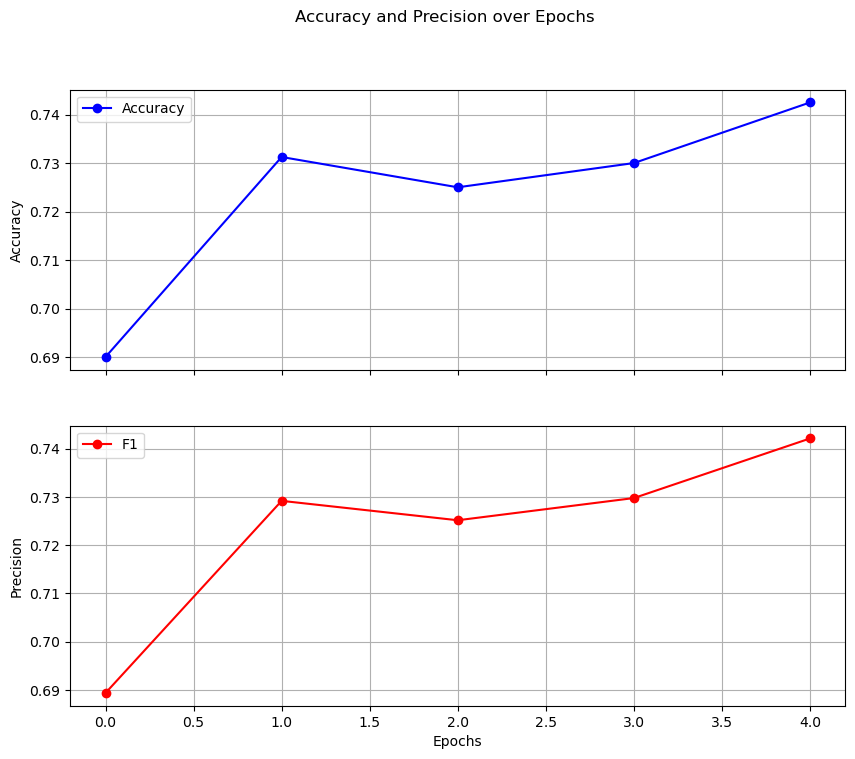

In [56]:
import numpy as np
import matplotlib.pyplot as plt

# Data for accuracy and precision
epochs = np.arange(5)  # Assuming you have 10 epochs

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Plot accuracy
ax1.plot(epochs, epoch_metrics_df_Deberta['accuracy'], label='Accuracy', marker='o', color='b')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# Plot precision
ax2.plot(epochs, epoch_metrics_df_Deberta['f1'], label='F1', marker='o', color='r')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Precision')
ax2.legend()
ax2.grid(True)

plt.suptitle('Accuracy and Precision over Epochs')
plt.show()

[[237  90   8]
 [ 41 262  19]
 [ 21  27  95]]


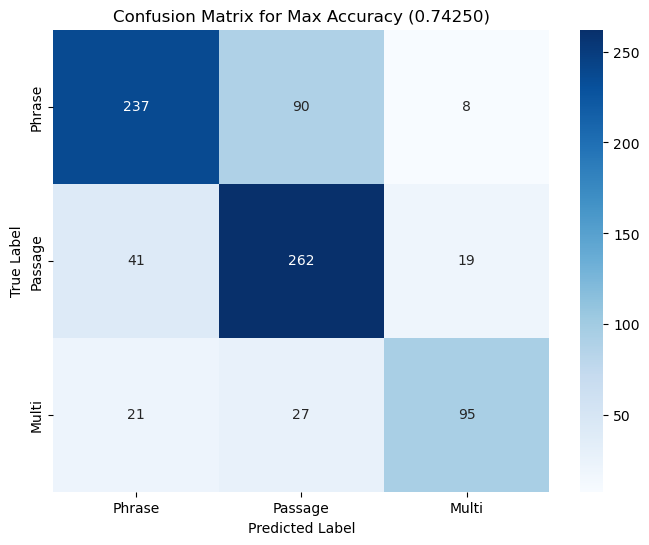

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Assuming you have a list of class labels
class_labels = ['Phrase', 'Passage', 'Multi']

# Assuming you already have the confusion matrix 'cm' with the maximum accuracy
max_accuracy = max(epoch_metrics_df_Deberta['accuracy'])
cm = epoch_metrics_df_Deberta.loc[epoch_metrics_df_Deberta['accuracy'] == max_accuracy, 'confusion_matrix'].to_numpy()[0]
print(cm)
# Plot the confusion matrix
plot_confusion_matrix(cm, classes=class_labels, title=f'Confusion Matrix for Max Accuracy ({max_accuracy:.5f})')


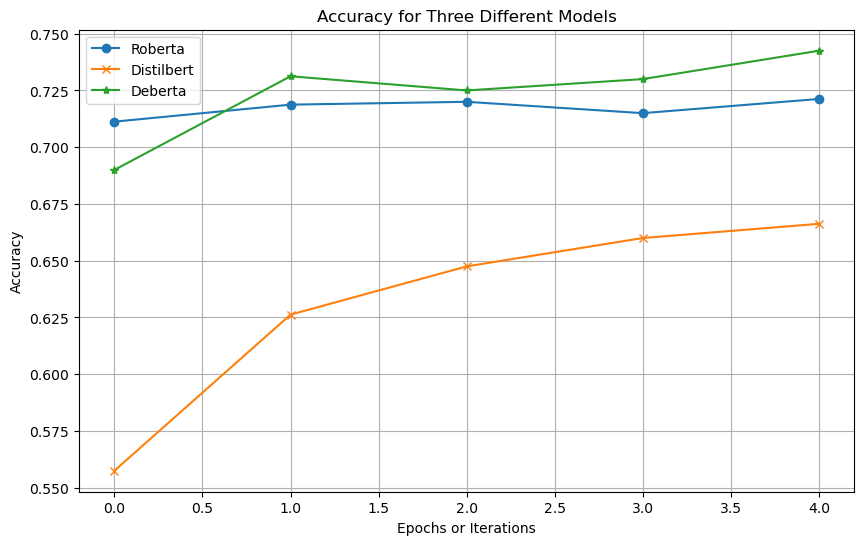

In [58]:


# Assuming you have the corresponding epochs or iterations for the x-axis
epochs = np.arange(5)

# Plot the accuracy values for all three models on the same graph
plt.figure(figsize=(10, 6))
plt.plot(epochs, epoch_metrics_df_roberta[5:10]['accuracy'], label='Roberta', marker='o')
plt.plot(epochs, epoch_metrics_df_DIST['accuracy'], label='Distilbert', marker='x')
plt.plot(epochs, epoch_metrics_df_Deberta['accuracy'], label='Deberta', marker='*')

plt.xlabel('Epochs or Iterations')
plt.ylabel('Accuracy')
plt.title('Accuracy for Three Different Models')
plt.legend()
plt.grid(True)
plt.show()


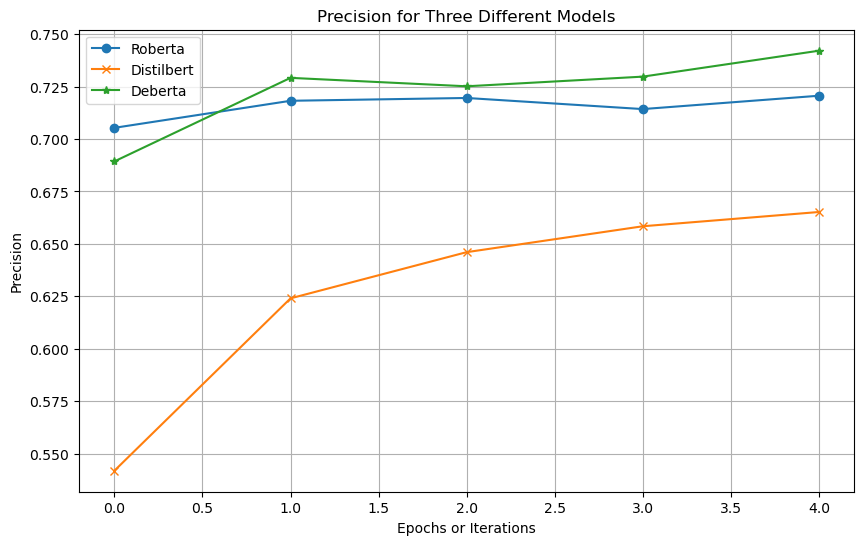

In [59]:


# Assuming you have the corresponding epochs or iterations for the x-axis
epochs = np.arange(5)

# Plot the accuracy values for all three models on the same graph
plt.figure(figsize=(10, 6))
plt.plot(epochs, epoch_metrics_df_roberta[5:10]['f1'], label='Roberta', marker='o')
plt.plot(epochs, epoch_metrics_df_DIST['f1'], label='Distilbert', marker='x')
plt.plot(epochs, epoch_metrics_df_Deberta['f1'], label='Deberta', marker='*')

plt.xlabel('Epochs or Iterations')
plt.ylabel('Precision')
plt.title('Precision for Three Different Models')
plt.legend()
plt.grid(True)
plt.show()
